# RandomForest Classifier Wild Fire Model Evaluation

This notebooks will tune and run Random Forest classifier on wildfire dataset in order to make a predecction on fire intensity.


#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [1]:
#optional code to ensure everyone is on the right version
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


In [2]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

# Import all the models and libraries needed

In [3]:
%matplotlib inline

import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier


from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling





# Helper function to save estimator
Saves to current working directory

In [4]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        

In [5]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

### Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally
Read a random sample.

Optimal testing data is 150K - SMOTE will generate additonal data for us

In [8]:
df_fires = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(5000)

print(df_fires.shape)

(5000, 26)


### Assess data in the file. 
Check data to ensure it's correct.


In [9]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [10]:
# review datagram
print (df_fires.shape)
df_fires.head(3) 

(5000, 26)


,Unnamed: 0,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat,bright_t31,frp
937991,937991,38.9987,-86.2078,87,3,2012,2012_6204,6,0,1,1,386.360442,2,51.34,0.38,0.0,9.216293,6.29,11.79,310.0,Medium,Moderate,Low,Low,290.9,10.3
839249,839249,31.6139,-102.4296,117,4,2011,2011_310,3,0,2,2,936.142272,3,65.99,0.12,0.0,9.997000,16.39,27.10,339.4,Severe,Moderate,Low,Low,317.1,33.7
388036,388036,31.3538,-86.8021,353,12,2006,2006_161,2,2,3,1140,7646.952224,2,76.45,0.53,0.0,8.722000,6.25,9.53,302.4,Low,Moderate,Low,Low,289.7,17.0


### Drop the columns not needed identified during the feature seleciton phase
Recommend Features:  'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust'

In [11]:
df_fires = df_fires.drop(columns={'Unnamed: 0', 'latitude', 'longitude','cluster_reference', 'doy', 
                                  'month', 'year', 'brightness', 'bright_t31','frp', 'visibility', 'covertype',
                                  'fire_intensity_twocat', 'fire_intensity', 'fire_intensity_threecat'})

In [12]:
df_fires.columns

Index(['fire_region', 'season', 'fuelcode', 'prefire_fuel',
       'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity',
       'wind_speed', 'wind_gust', 'fire_intensity_fourcat'],
      dtype='object')

In [13]:
#show the shape of the data
print(df_fires['fire_intensity_fourcat'].value_counts())

Low         4564
Moderate     373
High          49
Severe        14
Name: fire_intensity_fourcat, dtype: int64


### Setup the features for the pipeline

In [14]:
features = ['fire_region', 'season', 'fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 
             'wind_gust', 'wind_speed']

cat_features = ['fire_region', 'season', 'fuelcode', 'fuel_moisture_class']

num_features = ['prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust', 'wind_speed']

target = ['fire_intensity_fourcat'] # four categories using balanced binning

y = df_fires[target]
y = np.ravel(y)
X = df_fires[features]


### Setup the columns transfomer for the pipeline.

In [15]:
# Setup

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent'))])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))])

# Setting the transformation for the pipeline below. 
preprocessor = ColumnTransformer (transformers=[
        ('num_features', numeric_transformer, num_features),
        ('cat_features', categorical_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# Define the models to test
<b>Down to our best 2 models</b>

In [16]:
models = [ 
            RandomForestClassifier(),
           # GradientBoostingRegressor(),
        ]    


In [17]:
X.shape

(5000, 10)

# Function to Fit and predict the scores of the model. 
Give us our final scores

In [18]:
def score_model(X, y, estimator, **kwargs):
    
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='weighted')))
    
   
    return save_estimator(estimator)


# Iterate through the different models

In [19]:
for model in models:
    score_model(X, y, model)

RandomForestClassifier: 0.9970411969750812


# Function to visualize the model out using yellow brick classification report.


In [20]:
def visualize_model(X, y, estimator):
        
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
   

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model,
        classes=['Low', 'Medium', 'High', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )

                                           
    visualizer.fit(X_train, y_train)  
        
    visualizer.score(X_test, y_test)

       
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()
    
    
    from sklearn.metrics import confusion_matrix



# Iterate through the models to visualize

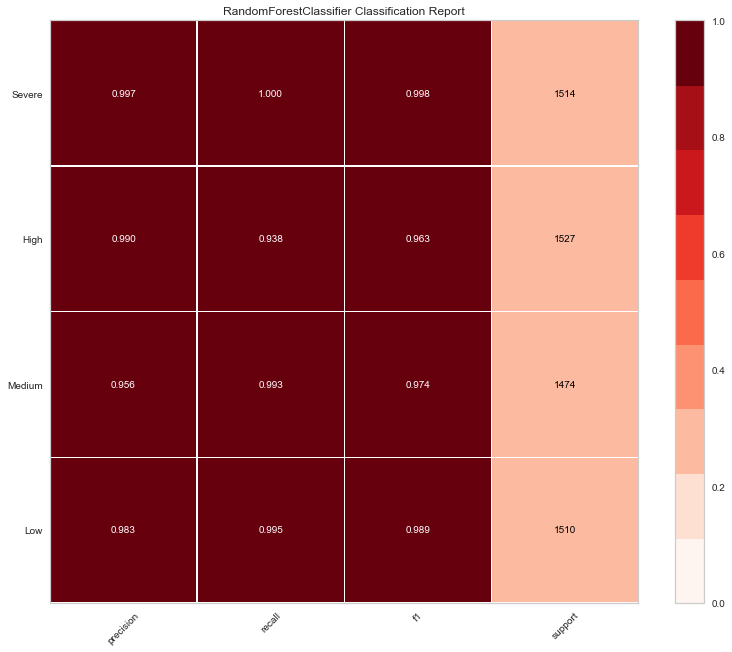

In [21]:
for model in models:
    visualize_model(X, y, model)
    

In [22]:
def confusion_matrix_report (X, y, estimator, **kwargs):
    
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs)  
    
    expected =  y_test
    predicted = model.predict(X_test)
    
    print(confusion_matrix(expected, predicted))
    print(classification_report(expected, predicted))

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

   
    return save_estimator(estimator)

In [23]:
for model in models:
   confusion_matrix_report(X, y, model)

[[1465   16   14    0]
 [  40 1318  177    3]
 [  42  111 1334    6]
 [   0    1    0 1498]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1495
           1       0.91      0.86      0.88      1538
           2       0.87      0.89      0.88      1493
           3       0.99      1.00      1.00      1499

    accuracy                           0.93      6025
   macro avg       0.93      0.93      0.93      6025
weighted avg       0.93      0.93      0.93      6025

RandomForestClassifier: 0.9319502074688797


---
#### ROCAUC For Bagging Classifier 

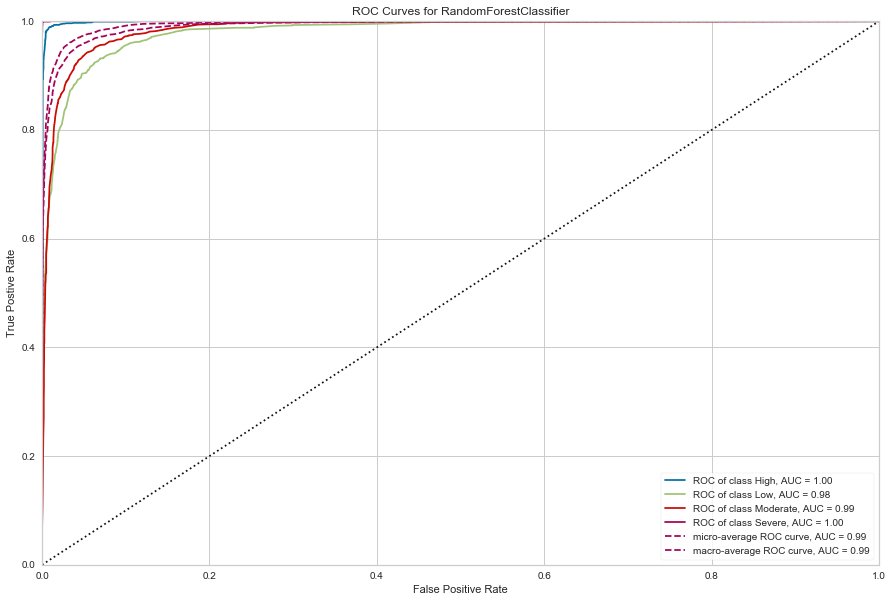

In [24]:

# Instantiate the classification model and visualizer
visualizer = ROCAUC(RandomForestClassifier(), size=(1080, 720))

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [26]:
import ipywidgets as widgets
from IPython.display import display

In [27]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [29]:
print(w.value)

50
